In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_squared_error

In [103]:
movie_rate = pd.read_csv("ds-ca-3-q-3/train_data_movie_rate.csv")
movie_trust = pd.read_csv("ds-ca-3-q-3/train_data_movie_trust.csv")

## Data Exploration

In [104]:
movie_rate.head()

,id,user_id,item_id,label
0,1,1,1,2.0
1,2,1,2,4.0
2,3,1,3,3.5
3,4,1,4,3.0
4,5,1,5,4.0


In [105]:
movie_trust.head()

,id,user_id_trustor,user_id_trustee,trust_value
0,1,2,966,1
1,2,2,104,1
2,3,5,1509,1
3,4,6,1192,1
4,5,7,1510,1


In [106]:
print(movie_rate.isnull().sum())
print(movie_trust.isnull().sum())

id         0
user_id    0
item_id    0
label      0
dtype: int64
id                 0
user_id_trustor    0
user_id_trustee    0
trust_value        0
dtype: int64


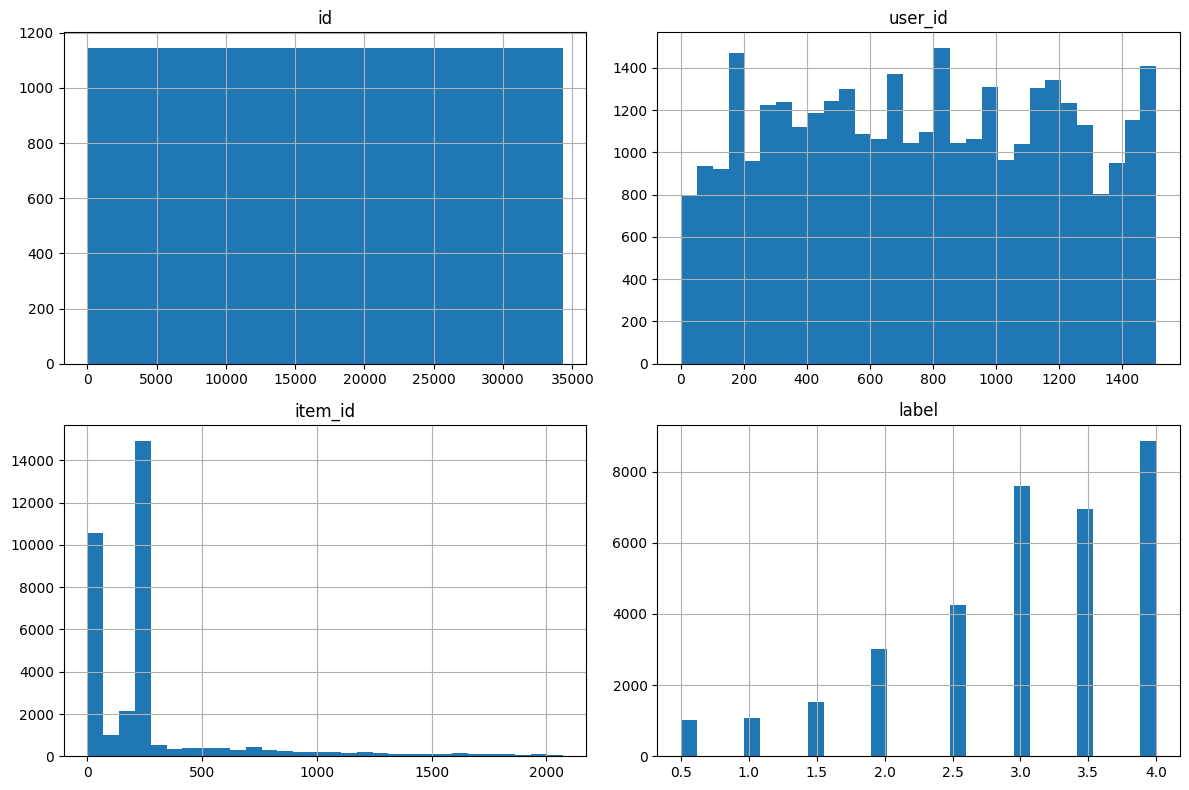

In [107]:
movie_rate.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

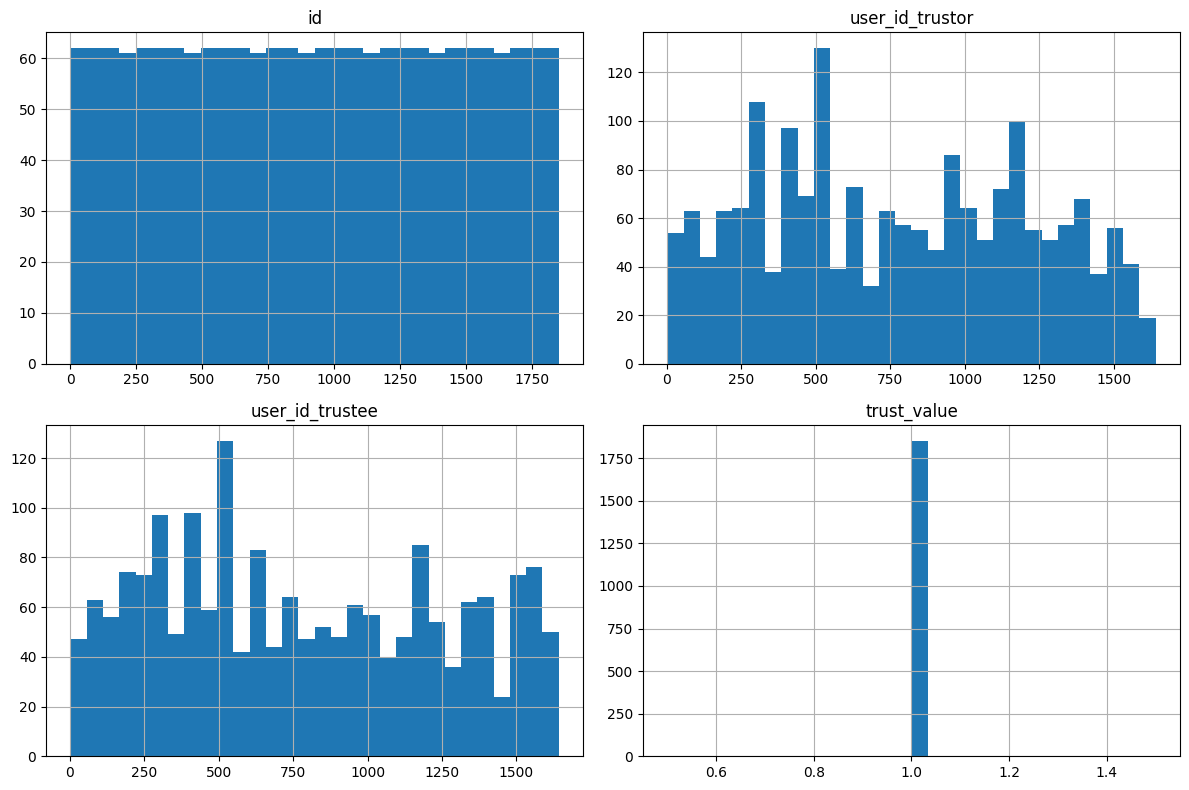

In [108]:
movie_trust.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

In [109]:
print(movie_rate.describe())
print(movie_trust.describe())

                 id       user_id       item_id         label
count  34298.000000  34298.000000  34298.000000  34298.000000
mean   17149.500000    764.002303    266.193452      3.006298
std     9901.124103    427.022738    349.849377      0.915706
min        1.000000      1.000000      1.000000      0.500000
25%     8575.250000    398.000000     12.000000      2.500000
50%    17149.500000    761.000000    216.000000      3.000000
75%    25723.750000   1142.000000    251.000000      4.000000
max    34298.000000   1508.000000   2071.000000      4.000000
                id  user_id_trustor  user_id_trustee  trust_value
count  1853.000000      1853.000000      1853.000000       1853.0
mean    927.000000       775.437669       782.192121          1.0
std     535.059343       447.736536       471.614626          0.0
min       1.000000         2.000000         2.000000          1.0
25%     464.000000       410.000000       395.000000          1.0
50%     927.000000       752.000000       716.

## preprocessing

In [110]:
duplicate_rows = movie_rate[movie_rate.duplicated()]
duplicate_rows

,id,user_id,item_id,label


In [111]:
duplicate_trust_rows = movie_trust[movie_trust.duplicated()]
duplicate_trust_rows

,id,user_id_trustor,user_id_trustee,trust_value


### Step 1: Merge Trust and Rating Data

In [89]:
# User A (trustor) trusts user B (trustee), and B rated movie M with rating R and trust value = T
trusted_ratings = movie_trust.merge(
    movie_rate,
    left_on='user_id_trustee',
    right_on='user_id',
    how='inner',
    suffixes=('_trust', '_rated')
)
trusted_ratings

,id_trust,user_id_trustor,user_id_trustee,trust_value,id_rated,user_id,item_id,label
0,1,2,966,1,21867,966,13,4.0
1,1,2,966,1,21868,966,2,3.5
2,1,2,966,1,21869,966,7,2.5
3,1,2,966,1,21870,966,216,3.0
4,1,2,966,1,21871,966,17,3.0
...,...,...,...,...,...,...,...,...
56748,1853,1508,938,1,21280,938,12,2.5
56749,1853,1508,938,1,21281,938,207,3.5
56750,1853,1508,938,1,21282,938,1246,3.0
56751,1853,1508,938,1,21283,938,1243,2.5


### Step 2: Compute Average Rating from Trusted Users

In [90]:
# user A trusts users B and C.
# And suppose B and C both rated movie X:
# B gave it 4
# C gave it 5
# trusted_avg_rating = (4 + 5) / 2 = 4.5

trusted_item_avg = trusted_ratings.groupby(['user_id_trustor', 'item_id']).agg(trusted_avg_rating=('label', 'mean')).reset_index()
trusted_item_avg

,user_id_trustor,item_id,trusted_avg_rating
0,2,2,3.50
1,2,4,4.00
2,2,5,3.50
3,2,7,3.25
4,2,9,3.50
...,...,...,...
42972,1641,787,4.00
42973,1641,1036,4.00
42974,1641,1037,2.00
42975,1641,1038,4.00


### Step 3: Merge Trusted Averages with Original Ratings

In [91]:
ratings_with_trust = movie_rate.merge(
    trusted_item_avg,
    left_on=['user_id', 'item_id'],
    right_on=['user_id_trustor', 'item_id'],
    how='left'
)
ratings_with_trust

,id,user_id,item_id,label,user_id_trustor,trusted_avg_rating
0,1,1,1,2.0,NaN,NaN
1,2,1,2,4.0,NaN,NaN
2,3,1,3,3.5,NaN,NaN
3,4,1,4,3.0,NaN,NaN
4,5,1,5,4.0,NaN,NaN
...,...,...,...,...,...,...
34293,34294,1508,84,3.5,NaN,NaN
34294,34295,1508,17,4.0,1508.0,2.75
34295,34296,1508,669,1.0,NaN,NaN
34296,34297,1508,686,2.5,1508.0,3.00


### Step 4: Compute User Average Ratings

In [ ]:
# User average rating:
user_avg = ratings_with_trust.groupby('user_id')['label'].mean().to_dict()
ratings_with_trust['user_avg'] = ratings_with_trust['user_id'].map(user_avg)
ratings_with_trust['trusted_avg_rating'] = ratings_with_trust['trusted_avg_rating'].fillna(ratings_with_trust['user_avg'])

### Step 5: Compute Item Average Ratings 

In [ ]:
# Item average rating
movie_avg = ratings_with_trust.groupby('item_id')['label'].mean().to_dict()
ratings_with_trust['item_avg'] = ratings_with_trust['item_id'].map(movie_avg)

### Step 6: Add Trust Count Feature

In [ ]:
# Trust count per user
trust_count = movie_trust.groupby('user_id_trustor').size().to_dict()
ratings_with_trust['trust_count'] = ratings_with_trust['user_id'].map(trust_count).fillna(0)

### Step 7: Add Item Rating Count Feature

In [ ]:
# Count how many users rated each item
item_rating_count = movie_rate.groupby('item_id').size()
ratings_with_trust['item_rating_count'] = ratings_with_trust['item_id'].map(item_rating_count)

### Step 8: Add Rating Deviation Feature

In [ ]:
# How much a user's average rating deviates from the item's average rating
ratings_with_trust['rating_diff'] = ratings_with_trust['user_avg'] - ratings_with_trust['item_avg']

### Step 9: Clean Up Columns

In [93]:
ratings_with_trust.drop(columns=['id','user_id_trustor'], inplace=True)

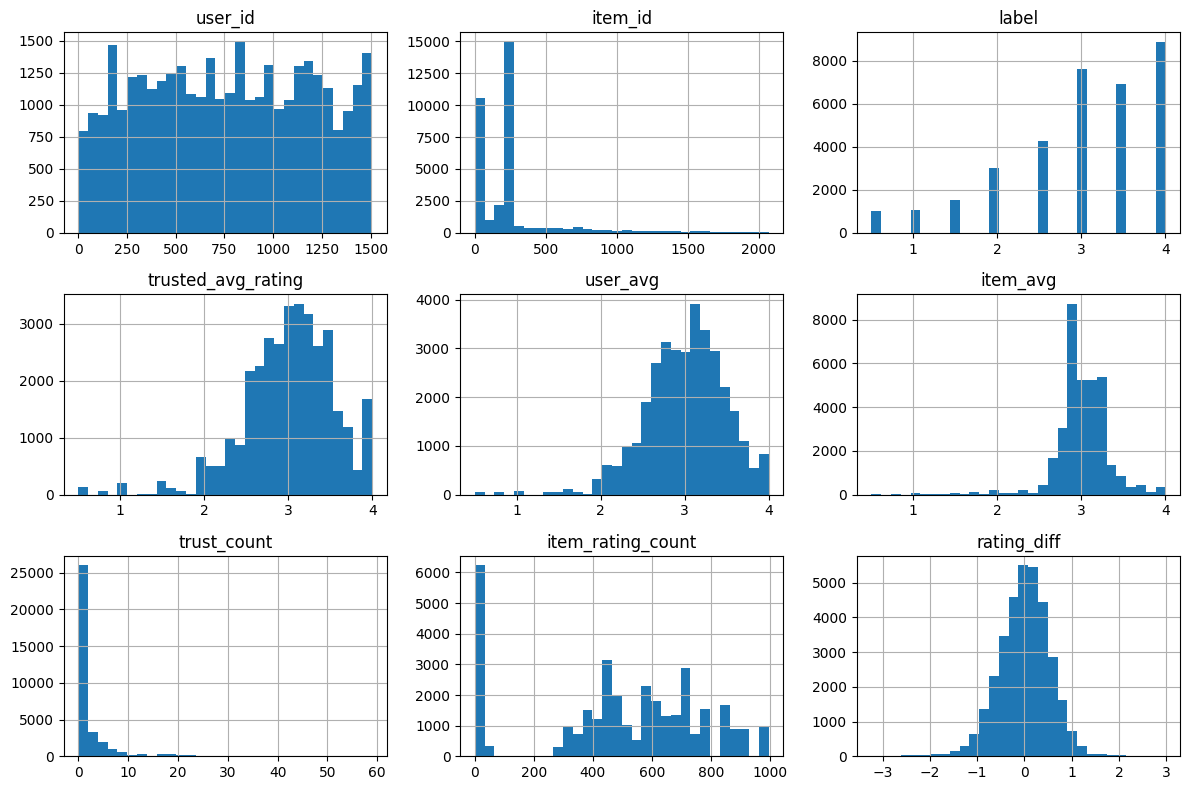

In [112]:
ratings_with_trust.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

### Step 10: Split Features and Target

In [94]:
X = ratings_with_trust.drop(columns=['label'])
y = ratings_with_trust['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 11: Normalize Numeric Features (excluding IDs)

In [ ]:
label_scaler = MinMaxScaler()
# y = label_scaler.fit_transform(y)

exclude_cols = ['user_id', 'item_id']
cols_to_normalize = [col for col in X_train.columns if col not in exclude_cols]

scaler = MinMaxScaler()
X_train[cols_to_normalize] = scaler.fit_transform(X_train[cols_to_normalize])
X_val[cols_to_normalize] = scaler.transform(X_val[cols_to_normalize])

In [96]:
X_train.head()

,user_id,item_id,trusted_avg_rating,user_avg,item_avg,trust_count,item_rating_count,rating_diff
32223,1430,211,0.534286,0.534286,0.769745,0.000000,0.579477,0.388205
15770,702,1452,0.750243,0.750243,0.571429,0.067797,0.001006,0.621501
21523,948,12,1.000000,0.763736,0.660004,0.016949,0.732394,0.579219
13573,608,257,0.727679,0.727679,0.631300,0.000000,0.515091,0.575077
20380,896,234,1.000000,1.000000,0.682121,0.000000,0.494970,0.699814


## Building the model

### Model Comparison and Hyperparameter Tuning

In [ ]:
# Define a set of baseline models to compare
models = {
    "XGBRegressor": XGBRegressor(random_state=42, verbosity=0),
    "LGBMRegressor": LGBMRegressor(random_state=42),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoostingRegressor": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=10),
    "Ridge": Ridge(alpha=1.0)
}

results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2score = r2_score(y_val, preds)
    results.append((name, mse, rmse, mae, r2score))

results_df = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "MAE", "R2_SCORE"]).sort_values(by="MSE")

print(results_df)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 27438, number of used features: 8
[LightGBM] [Info] Start training from score 3.011025
                       Model       MSE      RMSE       MAE  R2_SCORE
3  GradientBoostingRegressor  0.546923  0.739542  0.561229  0.369447
1              LGBMRegressor  0.548238  0.740431  0.561983  0.367931
5                      Ridge  0.549976  0.741604  0.568012  0.365927
0               XGBRegressor  0.572149  0.756405  0.570341  0.340364
2      RandomForestRegressor  0.598038  0.773329  0.581901  0.310516
4        KNeighborsRegressor  0.837582  0.915195  0.722843  0.034343


### Hyperparameter Tuning with GridSearchCV

In [114]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

lgbm_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5, 7],
    'num_leaves': [20, 40, 60],
    'reg_alpha': [0.0, 1.0],
    'reg_lambda': [0.0, 1.0]
}

lgbm_grid = GridSearchCV(
    LGBMRegressor(subsample=0.7, colsample_bytree=0.7, random_state=42),
    lgbm_params,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)
lgbm_grid.fit(X_train, y_train)
print("Best LGBM Params:", lgbm_grid.best_params_)

xgb_params = {
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.03],
    'max_depth': [3, 5],
    'gamma': [0, 1, 2],
    'reg_lambda': [1, 2],
    'reg_alpha': [0, 1]
}

xgb_grid = GridSearchCV(
    XGBRegressor(subsample=0.7, colsample_bytree=0.7, random_state=42, verbosity=0),
    xgb_params,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)
print("Best XGB Params:", xgb_grid.best_params_)

cat_params = {
    'iterations': [300, 500],
    'learning_rate': [0.01, 0.03],
    'depth': [4, 5, 6],
    'l2_leaf_reg': [3, 5, 7]
}

cat_grid = GridSearchCV(
    CatBoostRegressor(random_seed=42, verbose=0),
    cat_params,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)
cat_grid.fit(X_train, y_train)
print("Best CatBoost Params:", cat_grid.best_params_)

elastic_params = {
    'alpha': [0.01, 0.1, 1.0],
    'l1_ratio': [0.3, 0.5, 0.7, 0.9]
}

elastic_grid = GridSearchCV(
    ElasticNet(),
    elastic_params,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)
elastic_grid.fit(X_train, y_train)
print("Best ElasticNet Params:", elastic_grid.best_params_)

ridge_params = {
    'alpha': [1.0, 5.0, 10.0, 20.0]
}

ridge_grid = GridSearchCV(
    Ridge(),
    ridge_params,
    cv=3,
    scoring=scorer,
    n_jobs=-1,
    verbose=1
)
ridge_grid.fit(X_train, y_train)
print("Best Ridge Params:", ridge_grid.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1602
[LightGBM] [Info] Number of data points in the train set: 27438, number of used features: 8
[LightGBM] [Info] Start training from score 3.011025
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best LGBM Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 20, 'reg_alpha': 0.0, 'reg_lambda': 1.0}
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best XGB Params: {'gamma': 1, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 1}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\Users\Helia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Helia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Helia\AppData\Local\Programs\Python\Python39\lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline

Best CatBoost Params: {'depth': 5, 'iterations': 500, 'l2_leaf_reg': 7, 'learning_rate': 0.03}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best ElasticNet Params: {'alpha': 0.01, 'l1_ratio': 0.9}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Ridge Params: {'alpha': 1.0}


In [144]:
# LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    num_leaves=25,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=2,
    reg_lambda=2,
    reg_alpha=1,
    random_state=42,
    verbosity=0
)

# CatBoost
cat_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    depth=5,
    l2_leaf_reg=5,
    random_seed=42,
    verbose=0
)

# ElasticNet
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.7)

# Final estimator (more conservative)
final_estimator = Ridge(alpha=10.0)

# 3. Define StackingRegressor with passthrough
stacking_model = StackingRegressor(
    estimators=[
        ('lgbm', lgbm_model),
        ('xgb', xgb_model),
        ('cat', cat_model),
        ('elasticnet', elastic_model)
    ],
    final_estimator=final_estimator,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# 4. Train the model
stacking_model.fit(X_train, y_train)

# 5. Evaluate on validation set
y_val_pred = stacking_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Validation MSE: {val_mse:.5f}")

Validation MSE: 0.54258


# Predict

In [ ]:
test_data = pd.read_csv("ds-ca-3-q-3/test_data.csv")

# 1. Add 'trusted_avg_rating' for (user_id, item_id) pairs from training
trusted_avg_map = (
    ratings_with_trust
    .groupby(['user_id', 'item_id'])['trusted_avg_rating']
    .mean()
)

# Map trusted average rating to test data
test_data['trusted_avg_rating'] = test_data.set_index(['user_id', 'item_id']).index.map(trusted_avg_map)

# Fill missing trusted_avg_rating with global average if no match
test_data.fillna({'trusted_avg_rating': movie_rate['label'].mean()}, inplace=True)

# 2. Add average rating per user
test_data['user_avg'] = test_data['user_id'].map(user_avg)

# 3. Add average rating per item
test_data['item_avg'] = test_data['item_id'].map(movie_avg)

# 4. Add trust count per user
test_data['trust_count'] = test_data['user_id'].map(trust_count)

# 5. Add rating count per item
test_data['item_rating_count'] = test_data['item_id'].map(item_rating_count)

# 6. Add difference between user and item average ratings
test_data['rating_diff'] = test_data['user_avg'] - test_data['item_avg']

test_data.reset_index(drop=True, inplace=True)
test_data['trust_count'] = test_data['user_id'].map(trust_count)
test_data['trust_count'].fillna(0, inplace=True)

C:\Users\Helia\AppData\Local\Temp\ipykernel_11880\3646765839.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['trust_count'].fillna(0, inplace=True)


In [ ]:
exclude_cols = ['id', 'user_id', 'item_id']

cols_to_normalize = [col for col in test_data.columns if col not in exclude_cols]
test_data[cols_to_normalize] = scaler.transform(test_data[cols_to_normalize])

In [150]:
X_test = test_data[X_train.columns]
test_data['label'] = stacking_model.predict(X_test)

In [151]:
test_data

,id,user_id,item_id,trusted_avg_rating,user_avg,item_avg,trust_count,item_rating_count,rating_diff,label
0,1,6,211,0.716085,0.964286,0.769745,0.016949,0.579477,0.630357,3.870522
1,2,6,7,0.716085,0.964286,0.761378,0.016949,1.000000,0.635069,3.833620
2,3,16,2,0.716085,0.885714,0.768653,0.033898,0.879276,0.586725,3.628338
3,4,16,4,0.716085,0.885714,0.769420,0.033898,0.642857,0.586293,3.637855
4,5,16,11,0.716085,0.885714,0.822458,0.033898,0.906439,0.556425,3.755418
...,...,...,...,...,...,...,...,...,...,...
1711,1712,345,7,0.716085,0.750000,0.761378,0.050847,1.000000,0.514395,3.208886
1712,1713,345,207,0.716085,0.750000,0.681004,0.050847,0.841046,0.559658,2.923768
1713,1714,345,17,0.716085,0.750000,0.734929,0.050847,0.785714,0.529290,3.121815
1714,1715,345,211,0.716085,0.750000,0.769745,0.050847,0.579477,0.509683,3.303788


In [152]:
valid_ratings = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]

def round_to_nearest_rating(pred):
    return min(valid_ratings, key=lambda x: abs(x - pred))

test_data['label'] = test_data['label'].apply(round_to_nearest_rating)

In [153]:
submission = test_data[['id', 'label']]
submission

,id,label
0,1,4.0
1,2,4.0
2,3,3.5
3,4,3.5
4,5,4.0
...,...,...
1711,1712,3.0
1712,1713,3.0
1713,1714,3.0
1714,1715,3.5


In [154]:
submission['label'].value_counts()


label
3.0    751
3.5    372
2.5    276
4.0    125
2.0    114
1.5     56
1.0     21
0.5      1
Name: count, dtype: int64

In [ ]:
submission.to_csv('submission.csv', index=False)